*This is a Jupyter Notebook. It is an interactive document that contains both rich text elements such as figures, links, equations, etc. and executable code - in this case Python code (the grey boxes).
**How to use a Jupyter Notebook**: You can execute the blocks of code one at the time by placing the mouse in the grey box and pressing shift + enter. An asterisk will appear in the brackets at the top left of the box while the code is being executed (this may take few seconds) and turns into a number when the execution is over.*

*This notebook and underpinning code were developed by Francesca Pianosi (francesca.pianosi@bristol.ac.uk) and are distributed under the GPL 3.0 licence: https://www.gnu.org/licenses/gpl-3.0.html*


# GSA tutorial - Hydrological modelling example
Francesca Pianosi, Fanny Sarrazin, Andres Peñuela

In this Notebook we see how Global Sensitivity Analysis (GSA) can be used us to investigate the role and relative importance of model parameters on the model predictions, and therefore identify the most influential parameters on which estimation efforts should be focused on.

In this Notebook we will apply GSA to a hydrological model. A hydrological model takes time series of meteorological forcings (rainfall and temperature) over a river basin, and returns the time series of river flows at the basin outlet. Here we will use the GR6J model (Pushpalatha et al 2011), which has six parameters:
- X1	production store capacity [mm]
- X2	intercatchment exchange coefficient [mm/d]
- X3	routing store capacity [mm]
- X4	unit hydrograph time constant [d]
- X5	intercatchment exchange threshold [-]
- X6	exponential store depletion coefficient [mm]

We will use time series of precipitation, potential evaporation, and river flows of an example catchment, the Wick River at Tarroul: https://nrfa.ceh.ac.uk/data/station/spatial/1001.

To measure the model ability to fit the flow observations, we will use three metrics (all to be minimised):
- Correlation: $ \ \ \ C = ( r - 1 )^2 \ \ $ where $ \ \ \ r $ is the correlation between the observed flow time series ($Q^{obs}$) and the simulated flow time series ($Q^{sim}$)
- Variability: $ \ \ \ V = ( S_{sim} / S_{obs} - 1 )^2 \ \ $ where $S_{sim}$ ($S^{obs}$) is the standard deviation of the time series $Q^{sim}$ ($Q^{obs}$).
- Bias: $ \ \ \ B =  ( M_{sim} / M_{obs} - 1 )^2 \ \ $ where $M^{sim}$ ($M^{obs}$) is the mean of $Q^{sim}$ ($Q^{obs}$)

We will also use a fourth metric, which is widely used in hydrology under the name of King-Gupta Efficiency (https://en.wikipedia.org/wiki/Kling%E2%80%93Gupta_efficiency), and is a combination of C, V and B:

- King-Gupta Efficiency: $ \ \ \ KGE = 1 - \sqrt{ C + V + B } $ 

By definition, KGE varies between $- \infty $ and 1, where 1 is the value that would be achieved by a perfect model with no error in correlation, variability and bias. Differently from C, V and B thus, the KGE is to be maximised.

### Import libraries
Before starting, we need to import some packages

In [19]:
from __future__ import division, absolute_import, print_function

# General Python Packages needed for calculation
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Specific functions needed for model simulation and calibration
from GR6J import gr6j_sim as gr6j_sim
from PerfMetrics import CORR_ERR as CORR_ERR
from PerfMetrics import MEAN_ERR as MEAN_ERR
from PerfMetrics import STD_ERR as STD_ERR

# Install python package for interactive visualisation and import required functions:
%pip install -q ipywidgets
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import warnings
warnings.filterwarnings('ignore') # to hide warning messages
from IPython.display import display, HTML
# Increase size of output display cell:
display(HTML("""
<style>
    div.output_scroll {height: 40em; }
</style>
"""))

# Install SAFE package and import required functions
%pip install SAFEpython
import safepython.PAWN as PAWN # Module to calculate PAWN sensitivity indices
import safepython.plot_functions as pf # Module to visualize the results
from safepython.model_execution import model_execution # Module to execute the model
from safepython.sampling import AAT_sampling, AAT_sampling_extend # Functions to perform the input sampling
from safepython.util import aggregate_boot # Functions to perform bootstrapping


### Load rainfall, evap and flow data

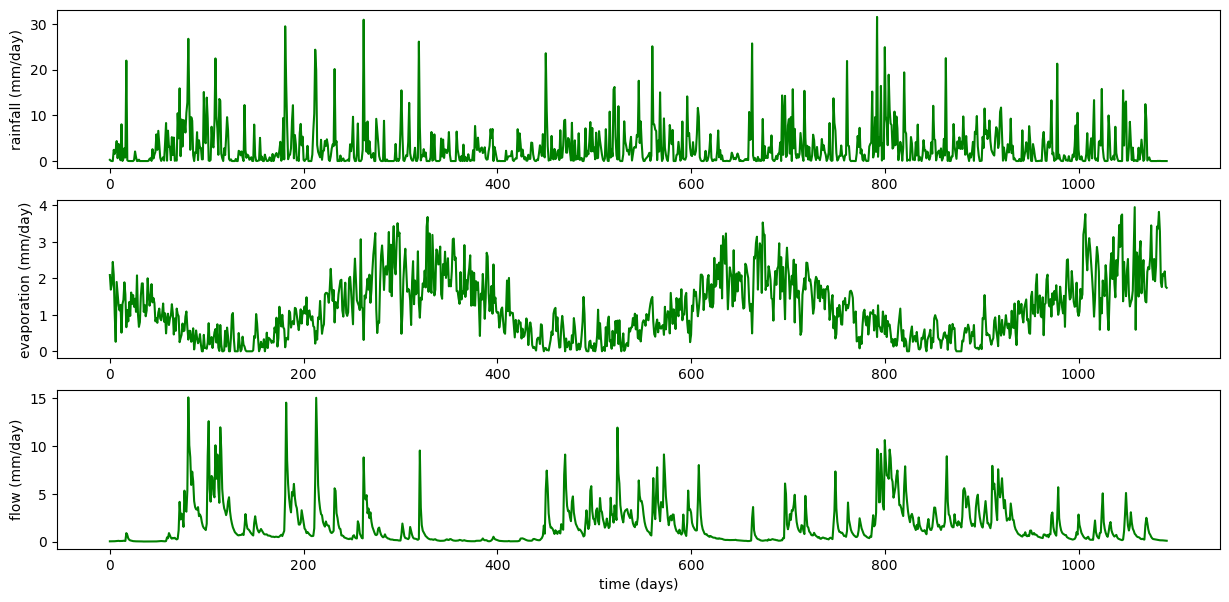

In [20]:
# Load the data:
data = pd.read_csv("CAMELS_GB_1001.csv")
rain = data["precipitation"].to_numpy() # (mm/day)
evap = data["pet"].to_numpy() # (mm/day)
flow = data["discharge_spec"].to_numpy() # (mm/day)

# Select a sub-period of the available time series for plotting and further analysis:
rain_sel = rain[280:280+364*3] # 
evap_sel = evap[280:280+364*3]
flow_sel = flow[280:280+364*3]

# Plot:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain_sel,'g'); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap_sel,'g'); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow_sel,'g'); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
           
plt.show()

## 1 - One-At-the-Time Sensitivity Analysis
We are now ready to run the GR6J model. To do this, we will set the six model parameters to some tentative values, run the model and plot the resulting streamflow time series. We can then change the parameter values one-at-a-time and look at how this changes the model predictions, and their fit to observed flows.

In [36]:
# Define interactive visualisation function to set the parameters to some tentative values, 
# run the model and plot the resulting streamflow time series

def oat_function(x1 = 200, x2 = 0.3, x3 = 100, x4 = 3, x5 = 0.6, x6 = 80 ):
    
    # Run simulation:
    x = np.array([x1, x2, x3, x4, x5, x6]) 
    flow_sim, _, _ = gr6j_sim(x, rain_sel, evap_sel, np.zeros((3, )))
    C = CORR_ERR(flow_sim, flow_sel)
    B = MEAN_ERR(flow_sim, flow_sel)
    V = STD_ERR(flow_sim, flow_sel)
    KGE = 1-(C+B+V)**0.5 
    # Plot hydrograph of observed and simulated flow:    
    fig = plt.figure(figsize=[12,3])    
    plt.plot(flow_sel, 'g') # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim']) 
    plt.title("Correlation: C = %0.3f" % C + ", Variability: V = %0.3f" % V + ", Bias: B = %0.3f" % B + ", KGE = %0.3f" % KGE, loc='center')
    plt.show()
   
interact(oat_function, x1 = (0, 400, 1), x2 = (0, 3, 0.1), x3 = (10,150,1), x4 = (0,10,1), x5 = (0.1,1,0.1), x6 = (0.1,100,1));

interactive(children=(IntSlider(value=200, description='x1', max=400), FloatSlider(value=0.3, description='x2'…

##  2 - Global Sensitivity Analysis
In this section, we run Monte Carlo (MC) simulations of the model against a prescribed number of parameter combinations, randomly drawn from the feasible parameter ranges. Each model simulation provides a times series of streamflow predictions. For each time series, we will measure the distance from observations through different performance metrics. We can then analyse the sensitivity of these metrics to the different parameters.

###  Run Monte Carlo simulations

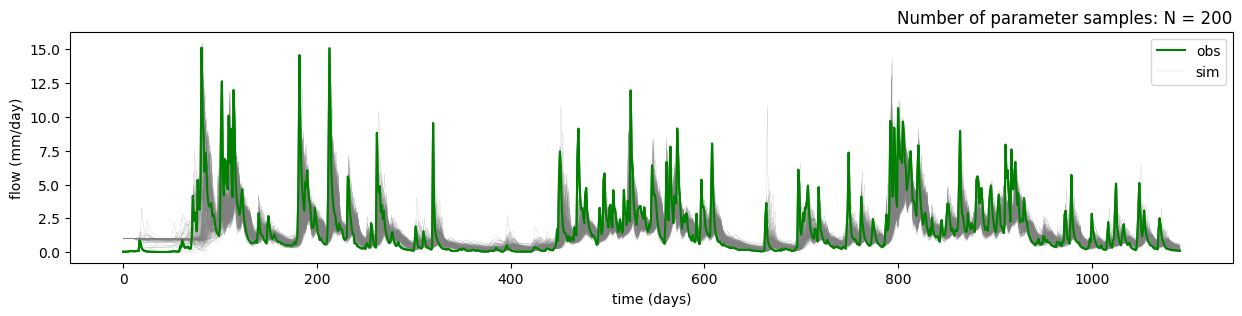

In [57]:
# Define variability ranges of the parameters:
xmin = [0  , 0,   10,  0, 0.1, 0.1] # min values
xmax = [300, 0.5,  50, 10, 0.5, 50  ] # max values
N = 200 # Number of samples
X_Labels = ['x1', 'x2', 'x3', 'x4', 'x5','x6'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters
samp_strat = 'lhs' # sampling strategy
distr_fun = st.uniform # Parameter distributions
# Save lower and upper bound in the appropriate format to be passed on to the sampling function:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
# Execute the model against all the input samples in 'X':
QQ = model_execution(gr6j_sim, X, rain_sel, evap_sel, np.zeros((3, )))
# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,3])
plt.plot(flow_sel, color='g') # plot for legend
plt.plot(np.transpose(QQ), 'grey', linewidth = 0.1)
plt.plot(flow_sel, color='g')
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Number of parameter samples: N = %d" % N, loc='right')
plt.show()

###  Aggregate time series into scalar output metric(s) and produce scatter plots:

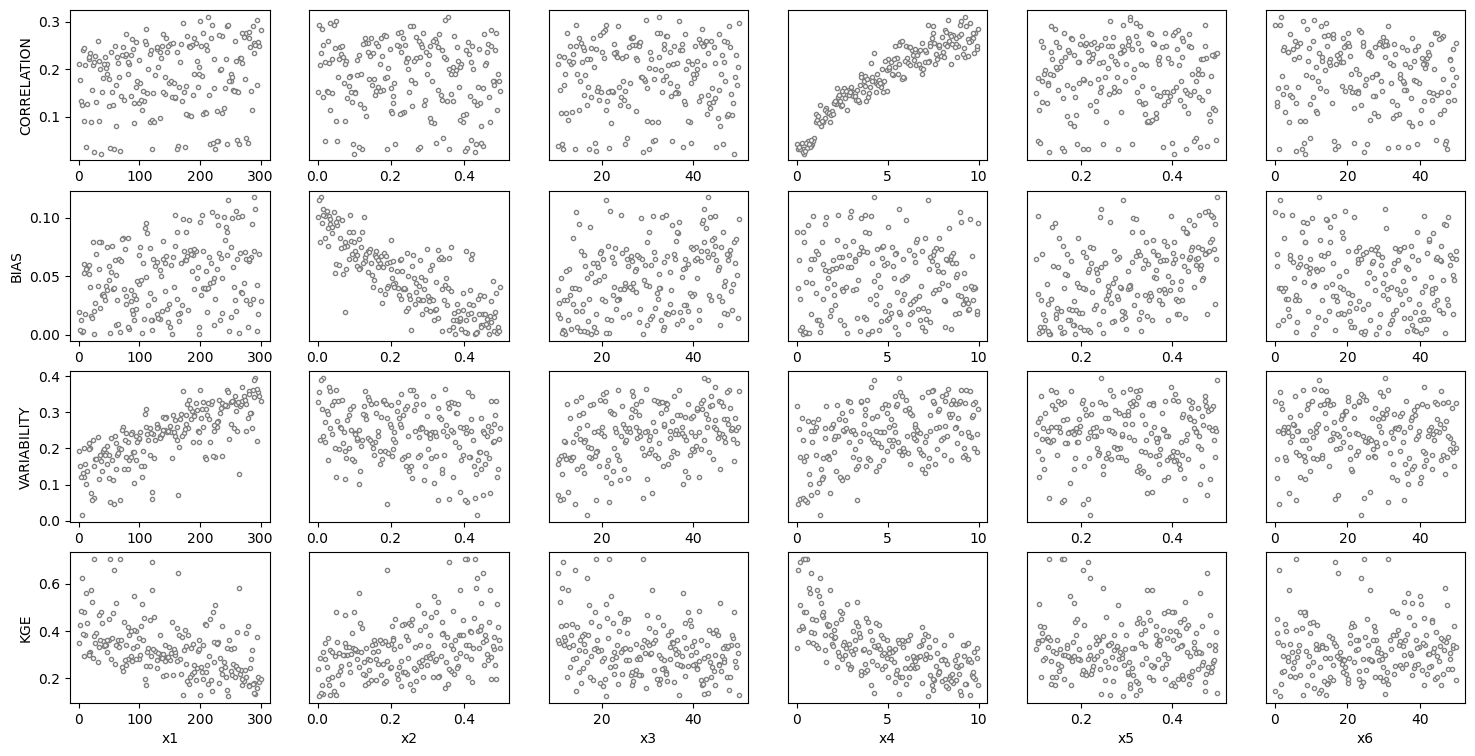

In [59]:
YY = np.nan * np.ones((N, 4))
YY[:, 0] = CORR_ERR(QQ, flow_sel)
YY[:, 1] = MEAN_ERR(QQ, flow_sel)
YY[:, 2] = STD_ERR(QQ, flow_sel)
YY[:, 3] = 1 - ( YY[:, 0]+YY[:, 1]+YY[:, 2] )**0.5
Y_Labels = ['CORRELATION','BIAS','VARIABILITY','KGE']
plt.figure(figsize=[18,9])
k=0
for j in range(P):    
    for i in range(M):
        plt.subplot(P,M,k+1)
        plt.plot(X[:, i], YY[:,j], '.', markerfacecolor="white", markeredgecolor="grey")        
        if i == 0:
            plt.ylabel(Y_Labels[j])
        else:
            plt.yticks([])
        if j == P-1:
            plt.xlabel(X_Labels[i])
        k=k+1        
plt.show()

### Questions:
* From these scatter plots, which parameter would you say is most influential? Why?
* How does the answer changes with the chosen performance metric?
* *Advanced hydrology question: Can you interpret why certain parameters are more important for a certain metric than others?*

### Calculate sensitivity indices

In [66]:
P=4
Y_Labels = ['CORRELATION','BIAS','VARIABILITY','KGE']

def pawn_function_allmetrics(n = 5, aggr = 'median',Nboot = 50):
        # Apply PAWN - Tuning parameters:
        # n = number of conditioning intervals
        # aggr = statistic to aggregate KS values
        # Nboot = number of bootstrapping resamples used to derive confidence bounds of sensitivity indices   
    plt.figure(figsize=[18,3])
    for j in range(P):       
        # Extract output metric:
        Y = YY[:, j];   
        # Compute sensitivity indices for Nboot bootstrap resamples
        KS_median, KS_mean, KS_max = PAWN.pawn_indices(X, Y, n, Nboot=Nboot) # shape (Nboot, M)        
        # Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:
        KS_median_m, KS_median_lb, KS_median_ub = aggregate_boot(KS_median) # shape (M,)
        KS_mean_m, KS_mean_lb, KS_mean_ub = aggregate_boot(KS_mean) # shape (M,)
        KS_max_m, KS_max_lb, KS_max_ub = aggregate_boot(KS_max) # shape (M,)
        # Plot sensitivity indices:
        plt.subplot(1,4,j+1)
        fs = 10 
        plt.title("Output metric = %s" % Y_Labels[j],fontsize=fs)
        if aggr == 'median':
            pf.boxplot1(KS_median_m, S_lb=KS_median_lb, S_ub=KS_median_ub, X_Labels=X_Labels)
        if aggr == 'mean':
            pf.boxplot1(KS_mean_m, S_lb=KS_mean_lb, S_ub=KS_mean_ub, X_Labels=X_Labels)
        if aggr == 'max':
            pf.boxplot1(KS_max_m, S_lb=KS_max_lb, S_ub=KS_max_ub, X_Labels=X_Labels)
        if j > 0:
            plt.ylabel(''); 
        else:
            plt.ylabel('sensitivity',fontsize=fs)     
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)        
    plt.show()
    
interact(pawn_function_allmetrics, n = (3, 15, 1), aggr = ['median', 'mean','max'], Nboot = (0, 100, 10));


interactive(children=(IntSlider(value=5, description='n', max=15, min=3), Dropdown(description='aggr', options…

### Questions:
* Which parameter are most influential on each performance metric?
* Are these results consistent with the visual inspection of the scatter plots?
* *Advanced GSA question: What is the impact of changing n and Nboot? Why?*

### References

Pushpalatha, R., Perrin, C., Le Moine, N., Mathevet, T. and Andréassian, V. (2011). A downward structural sensitivity analysis of hydrological models to improve low-flow simulation. Journal of Hydrology, 411(1-2), 66-76, doi:10.1016/j.jhydrol.2011.09.034.

